In [1]:
%load_ext autoreload

In [2]:
%autoreload

import h2o
import pandas as pd
import seaborn as sns
import utilities as utils

from h2o.automl import H2OAutoML

### Import data and format with utilities.py

In [3]:
data_list = utils.read_data()
Data = utils.DataProcessor(data_list)
df = Data.create_train_data()
df.sort_index(inplace=True)
df = df.loc['2019-09-04 08:00:00':]

df.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_w_1000hPa:ms,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,building,pv_measurement
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-09-04 08:00:00,6.9,1.231,2103.100098,1166053.375,382.100006,2103.100098,0.0,278.600006,66.400002,226964.906250,...,-0.0,8,2,3,9,2019,247,4,1,570.1125
2019-09-04 08:00:00,6.8,1.226,2104.000000,1166048.250,382.100006,2104.000000,0.0,278.600006,66.400002,226962.703125,...,-0.0,8,2,3,9,2019,247,4,0,3786.2000
2019-09-04 08:00:00,6.7,1.223,2122.699951,1167217.875,382.500000,2122.699951,0.0,278.399994,66.099998,225542.296875,...,-0.0,8,2,3,9,2019,247,4,2,137.2000
2019-09-04 09:00:00,6.7,1.225,2476.500000,1559157.375,479.700012,2476.500000,0.0,278.399994,73.199997,251260.000000,...,-0.0,9,2,3,9,2019,247,4,1,542.5125
2019-09-04 09:00:00,6.7,1.220,2478.399902,1559161.250,479.700012,2478.399902,0.0,278.399994,73.199997,251256.593750,...,-0.0,9,2,3,9,2019,247,4,0,3400.7600


In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21+35-LTS-2513, mixed mode, sharing)
  Starting server from C:\Users\elias\AppData\Local\Programs\Python\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\elias\AppData\Local\Temp\tmpwv0killl
  JVM stdout: C:\Users\elias\AppData\Local\Temp\tmpwv0killl\h2o_elias_started_from_python.out
  JVM stderr: C:\Users\elias\AppData\Local\Temp\tmpwv0killl\h2o_elias_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_elias_uhhg8a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.980 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


## Feature Engineering with Featurewiz
Featurewiz not working on Windows desktop. Use features from featurewiz from Ubuntu.

In [5]:
FEATURES = ['elevation:m', 'sun_elevation:d', 'direct_rad_1h:J', 'sun_azimuth:d', 'effective_cloud_cover:p', 'msl_pressure:hPa', 't_1000hPa:K', 'day_of_year', 'wind_speed_u_10m:ms', 'ceiling_height_agl:m',
            'visibility:m', 'relative_humidity_1000hPa:p', 'year', 'day_of_month', 'day_of_week', 'fresh_snow_24h:cm', 'fresh_snow_6h:cm', 'fresh_snow_1h:cm', 'pv_measurement']

TARGET = ['pv_measurement']

X_train_wiz = df[FEATURES]
y_train_wiz = df[TARGET]

## AutoML with H2O

In [6]:
data = X_train_wiz.copy()

# Convert to h2o frame
data = h2o.H2OFrame(data)
y = 'pv_measurement'
X = data.columns.remove(y)

# Split the data into train and test sets for validation
train, test = data.split_frame(ratios=[0.8])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
%%time
# Initialize and train the H2OAutoML model
aml = H2OAutoML(max_models=30, seed=1)
aml.train(x=X, y=y, training_frame=train)

AutoML progress: |
21:41:44.681: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
CPU times: total: 7.94 s
Wall time: 1h 7min 33s


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/30
# GBM base models (used / total),5/14
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/13
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [8]:
# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

model_id                                                    rmse       mse       mae       rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20231011_214144     231.577   53627.9   78.4249  nan                          53627.9
StackedEnsemble_BestOfFamily_1_AutoML_1_20231011_214144  235.659   55535     76.933   nan                          55535
GBM_grid_1_AutoML_1_20231011_214144_model_5              236.244   55811.3   76.0494  nan                          55811.3
GBM_4_AutoML_1_20231011_214144                           237.953   56621.5   82.5077  nan                          56621.5
GBM_3_AutoML_1_20231011_214144                           242.071   58598.3   83.5382  nan                          58598.3
GBM_1_AutoML_1_20231011_214144                           246.49    60757.2   87.7614  nan                          60757.2
GBM_2_AutoML_1_20231011_214144                           247.148   61082.1   86.4555  nan                          61082.1
DRF_1_AutoML_1_202

In [9]:
# Predict on the test data
preds = aml.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [16]:
# Cast preds to pd.DataFrame and save to csv
preds_df = preds.as_data_frame()

# Set all negative values to 0
preds_df[preds_df < 0] = 0

preds_df.to_csv('h2o_automl_preds2.csv', index=True)


<Axes: >

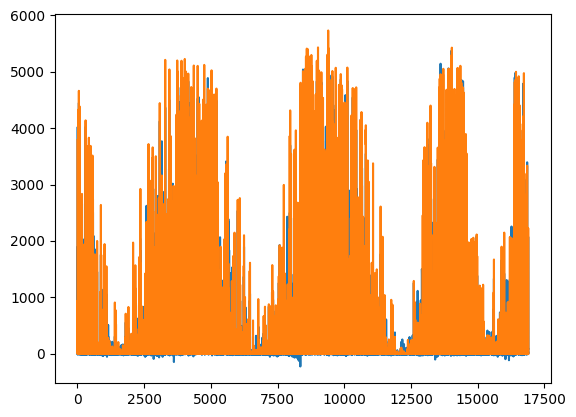